<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/notebooks/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time


<ipython-input-1-8d6f29fb6e1e>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
!wget https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg

--2023-05-16 15:04:42--  https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/l98leemr7r5stnm/Hemanvi.jpeg [following]
--2023-05-16 15:04:43--  https://www.dropbox.com/s/raw/l98leemr7r5stnm/Hemanvi.jpeg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9ba86f1ba76006adeef37226f8.dl.dropboxusercontent.com/cd/0/inline/B8JloKudhNROqWP_xjIIP9Sm7GhM-egmcR9ymEMP3BI6m39TQIBmNaGw7_dfee27JQ17QTDUCyttzZHwVXjhpYC7vE_7rvyu1xAStox1yXMGa3Km8XVjKe1BqXb0b_WnR9PDY0-NycV-2BzE2karvi4JQG2XGiMT7YrTIwcZR8d9ng/file# [following]
--2023-05-16 15:04:43--  https://uc9ba86f1ba76006adeef37226f8.dl.dropboxusercontent.com/cd/0/inline/B8JloKudhNROqWP_xjIIP9Sm7GhM-egmcR9ymEMP3BI6m39TQIBmNaGw7_dfee27JQ17QTDUCyttzZHw

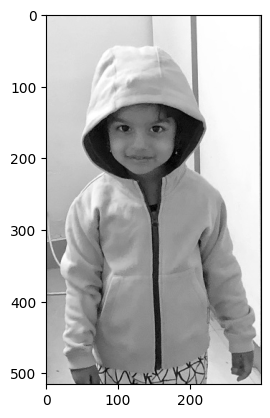

In [6]:
import cv2, matplotlib.pyplot as plt
img = cv2.imread('Hemanvi.jpeg')


img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Show image
plt.imshow(img_gray, cmap='gray')

# Convert the image into a 25 x 25 array and plot it:

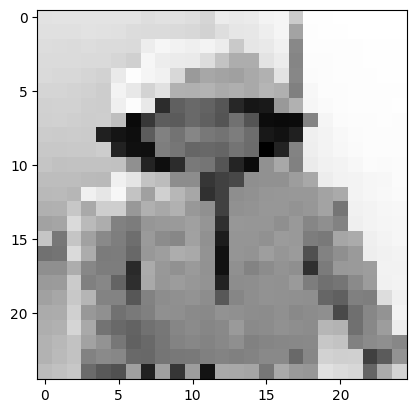

In [7]:
img_gray_small = cv2.resize(img_gray,(25,25))
plt.imshow(img_gray_small, cmap='gray')

In [8]:
print(img_gray_small)

[[226 227 227 227 227 227 227 223 225 225 223 214 236 233 235 243 245 204
  254 254 255 255 255 255 255]
 [224 224 224 226 225 224 221 220 220 219 217 211 223 230 231 238 245 166
  253 254 254 255 255 255 255]
 [222 221 220 222 220 220 219 237 246 242 239 244 236 202 230 233 241 139
  253 253 253 253 254 254 254]
 [220 220 220 219 219 215 209 246 237 235 234 222 196 175 175 228 236 136
  252 252 253 253 254 254 254]
 [219 217 217 214 211 234 253 245 241 217 157 169 165 162 171 179 228 138
  251 252 253 253 253 254 254]
 [214 214 213 210 206 243 232 213 225 179 178 181 173 177 171 183 178 131
  247 252 252 253 253 253 253]
 [210 211 211 207 206 239 252 233  51 100 109 103  91  45  29  32 156 179
  246 250 252 253 253 253 254]
 [209 210 208 206 207 192  17  61  98  96 110 100  89 118  89  19  17  18
  134 245 251 252 252 253 252]
 [205 204 205 204  39  27  21  97 132 119 137 124 119 129 113  31  25  39
  239 243 248 251 252 252 252]
 [201 201 202 202 206  40  23  22 130 122 106 108 105 1

- Histogram feature: For some tasks, such as auto-brightness or night vision, it is important to understand the illumination in the picture; that is, the fraction of pixels that are bright or dark. The following graph shows a histogram for the example image.

- Edges and Corners feature: For tasks such as image segmentation, where it is important to find the set of pixels corresponding to each person, it makes sense to extract the edges first because the border of a person is just a collection of edges. In other tasks, such as image registration, it is vital that key landmarks are detected. These landmarks will be a subset of all the corners in an image.

- Color separation feature: In tasks such as traffic light detection for a self-driving car, it is important that the system understands what color is being displayed on the traffic lights.

- Image gradients feature: Taking this a step further, it might be important to understand how the colors are changing at the pixel level. Different textures can give us different gradients, which means they can be used as texture detectors. 

# Preparing our data for image classification

In [9]:
import torchvision 
from torchvision import transforms

In [11]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(1)

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

<ipython-input-11-fdc52bcf6d38>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [15]:
fmnist = torchvision.datasets.FashionMNIST("./data", train=True, download=True, transform=transforms.ToTensor())
val_fmnist = torchvision.datasets.FashionMNIST("./data", train=False, download=True, transform=transforms.ToTensor())
x_example, y_example = fmnist[0]
type(x_example)

torch.Tensor

In [16]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [13]:
val_images = val_fmnist.data
val_targets = val_fmnist.targets

# Inspect the tensors that we are dealing with:

In [17]:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


3. Plot a random sample of 10 images for all the 10 possible classes:

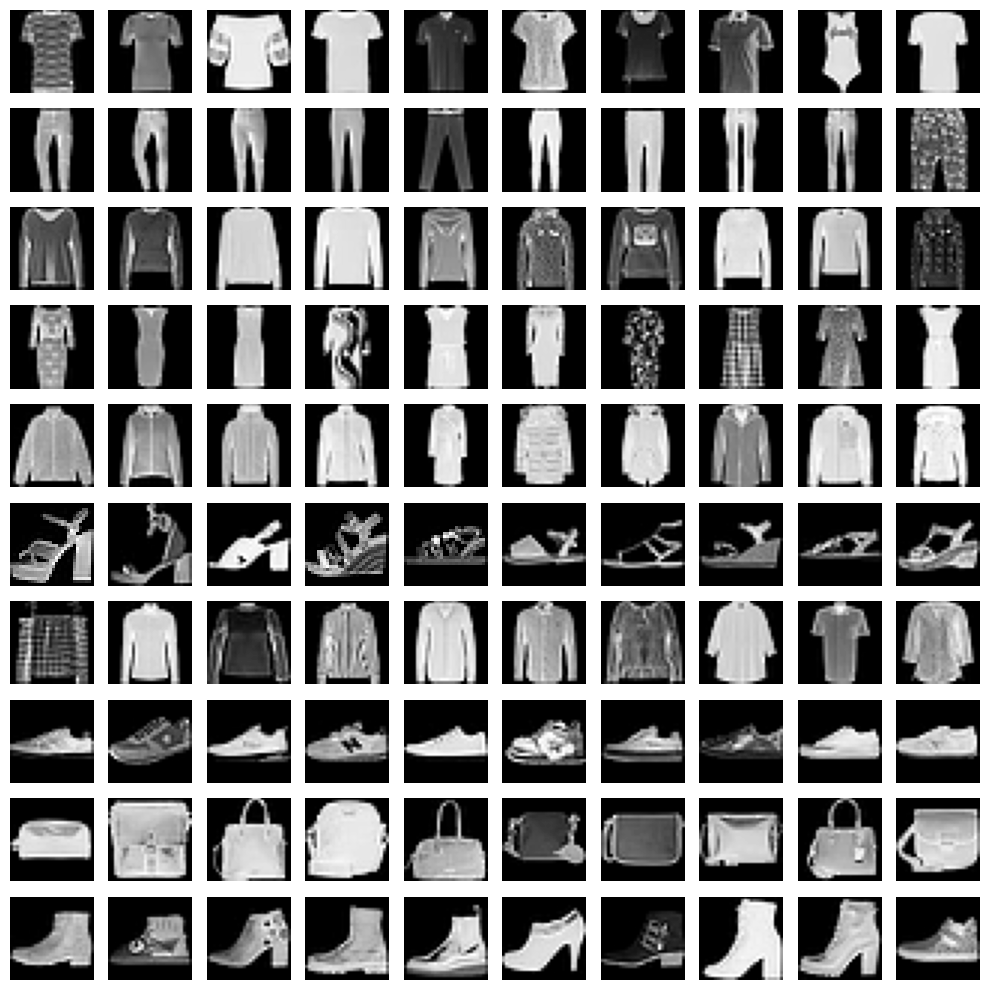

In [18]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]

    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

# Training a neural network
To train a neural network, we must perform the following steps:

- Import the relevant packages.
- Build a dataset that can fetch data one data point at a time.
- Wrap the DataLoader from the dataset.
- Build a model and then define the loss function and the optimizer.
- Define two functions to train and validate a batch of data, respectively.
- Define a function that will calculate the accuracy of the data.
- Perform weight updates based on each batch of data over increasing epochs.

1. Note that in the __init__ method, we have converted the input into a floating-point number and have also flattened each image into 28*28 = 784 numeric values (where each numeric value corresponds to a pixel value). We are also specifying the number of data points in the __len__ method; here, it is the length of x. The __getitem__ method contains logic for what should be returned when we ask for thee ixth data points (ix will be an integer between 0 and __len__).

2. Define a model, as well as the loss function and the optimizer:  The model is a network with one hidden layer containing 1,000 neurons. The output is a 10-neuron layer since there are 10 possible classes. Furthermore, we are calling the CrossEntropyLoss function since the output can belong to any of the 10 classes for each image. Finally, the key aspect to note in this exercise is that we have initialized the learning rate, lr, to a value of 0.01 and not the default of 0.001 to see how the model will learn for this exercise.

3. Define a function that will train the dataset on a batch of images

4. Build a function that calculates the accuracy of a given dataset: In the preceding lines of code, we are explicitly mentioning that we don't need to calculate the gradient by providing @torch.no_grad() and calculating the prediction values by feed-forwarding input through the model.

In [20]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,1,28,28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach 
    # dropout section
    # call your model like any python function on your batch 
    # of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the 
    # gradients of 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) 
    # where "f" is the optimizer
    optimizer.step()
    # Flush gradients memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval() # <- let's wait till we get to dropout 
    # section
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row 
    # coincides with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()


Create a function that generates a training DataLoader – trn_dl from the dataset – called FMNISTDataset. This will sample 32 data points at random for the batch size:

In [22]:
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [21]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [23]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [24]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB

In [25]:

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


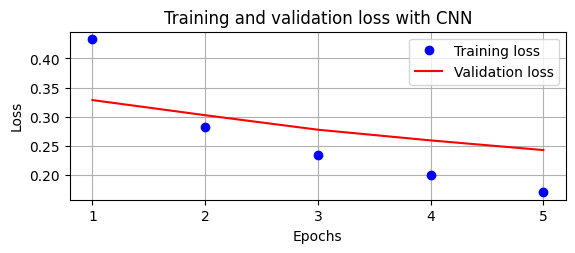

<ipython-input-27-7a9e3eea833f>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


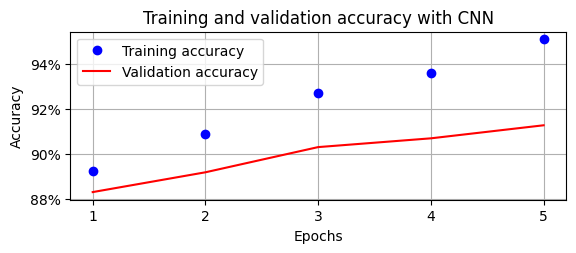

In [27]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()


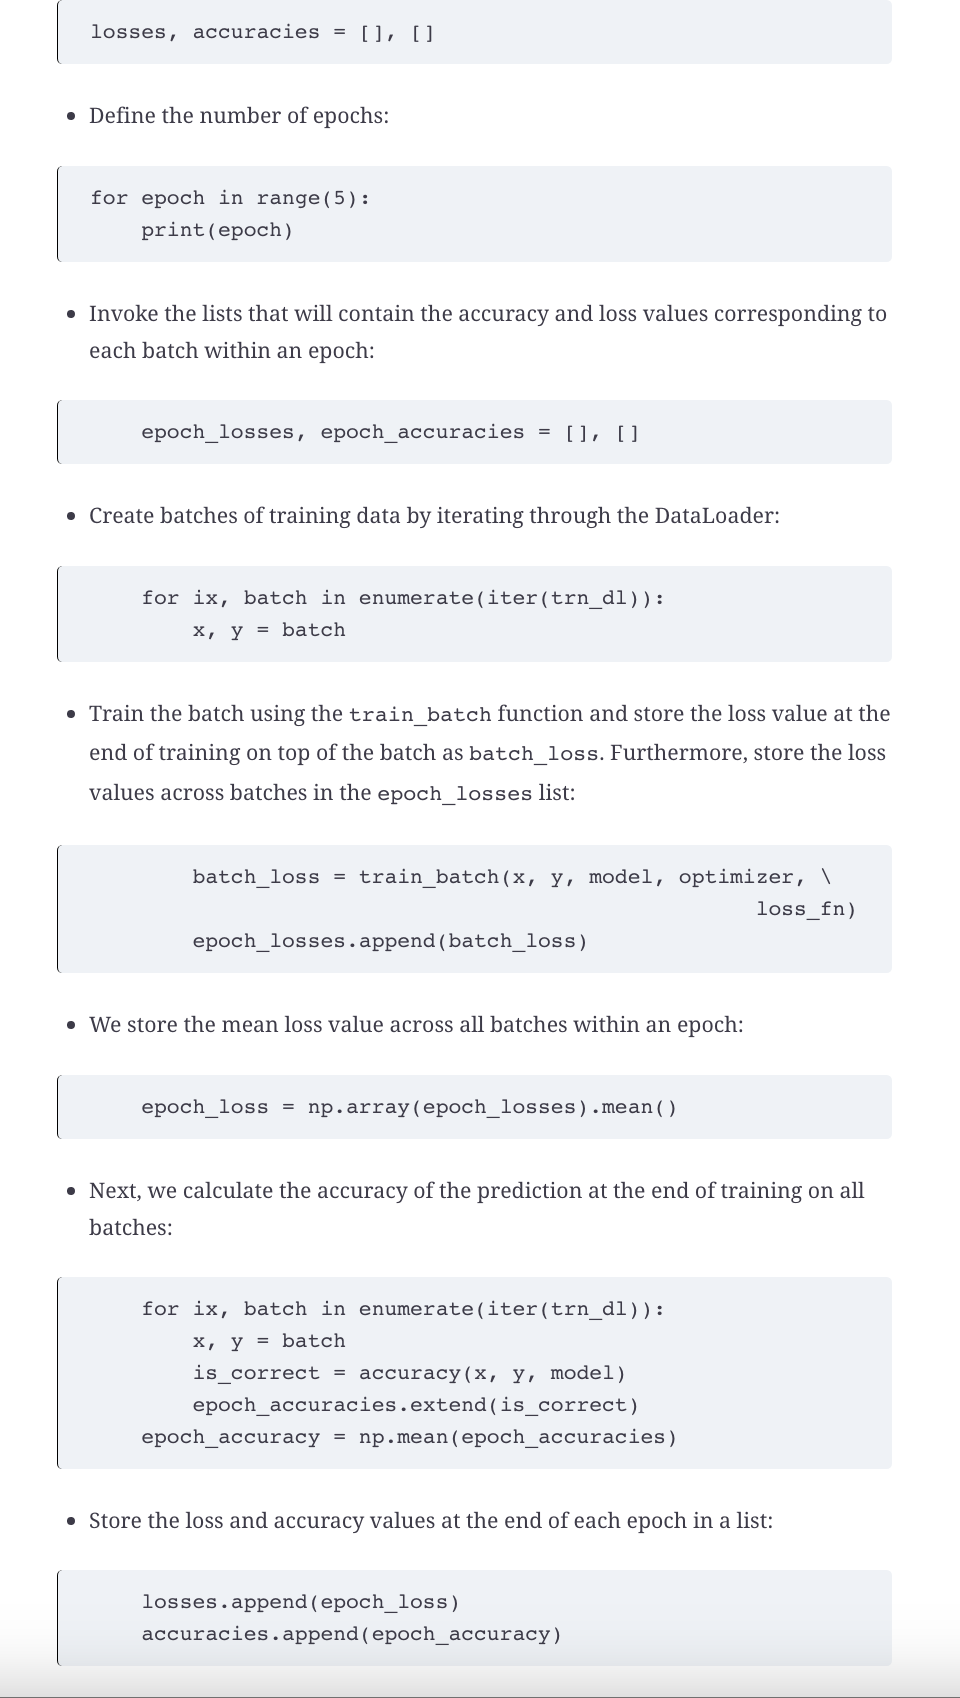

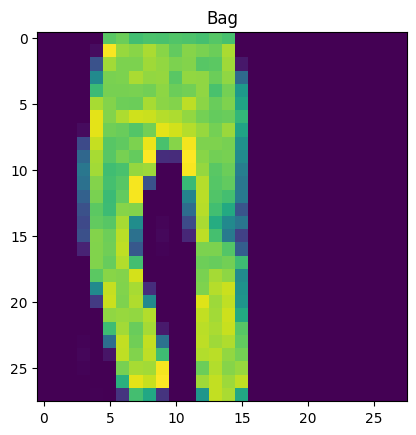

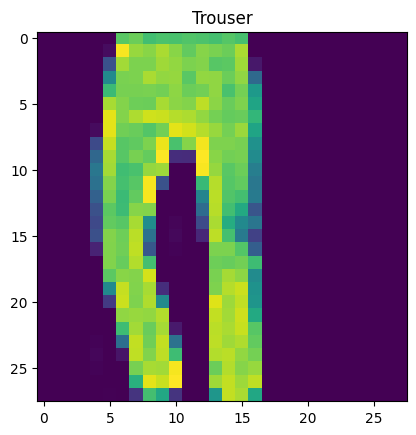

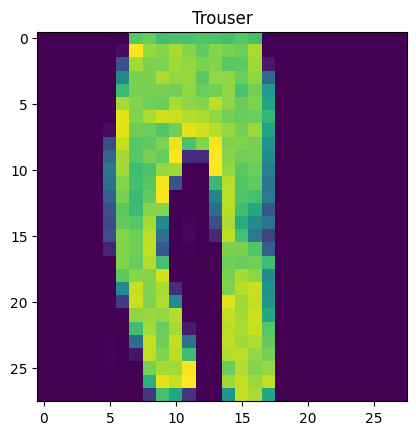

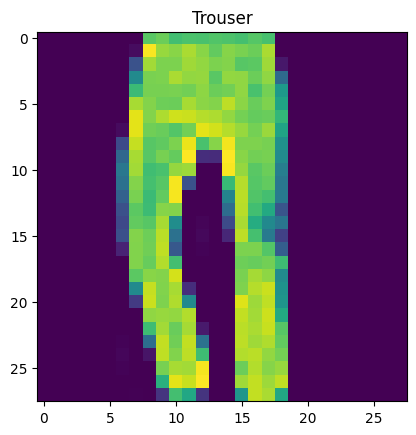

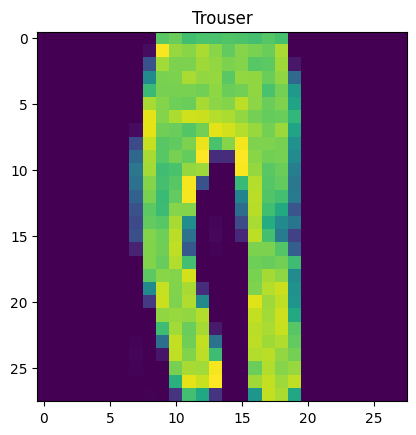

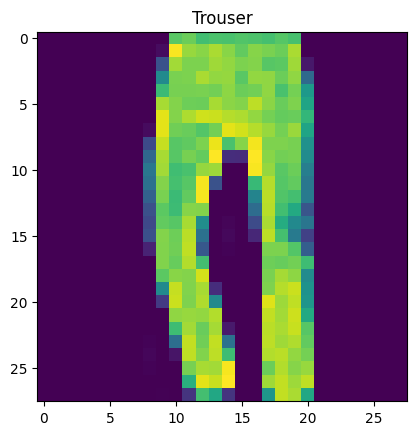

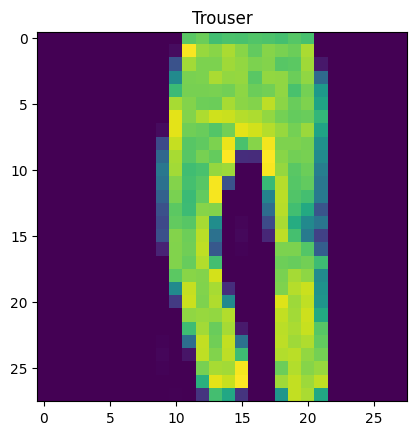

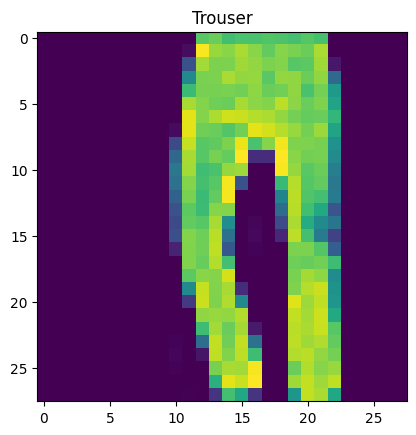

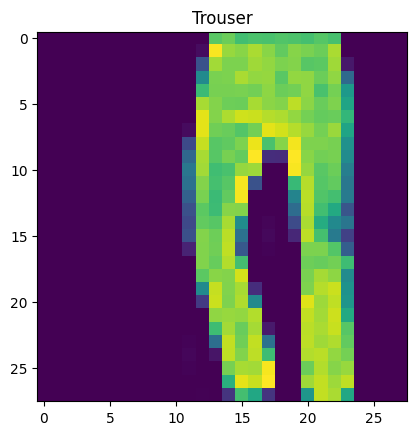

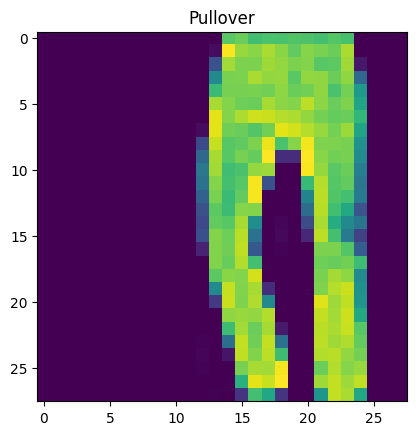

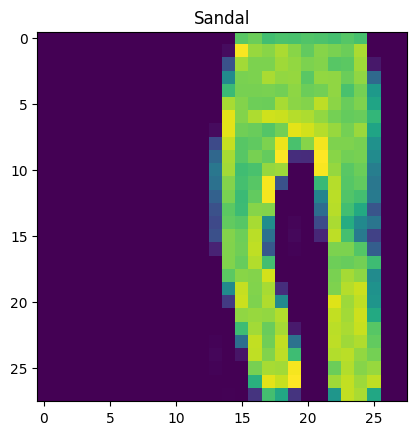

In [28]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

<Axes: title={'center': 'Probability of each class for various translations'}>

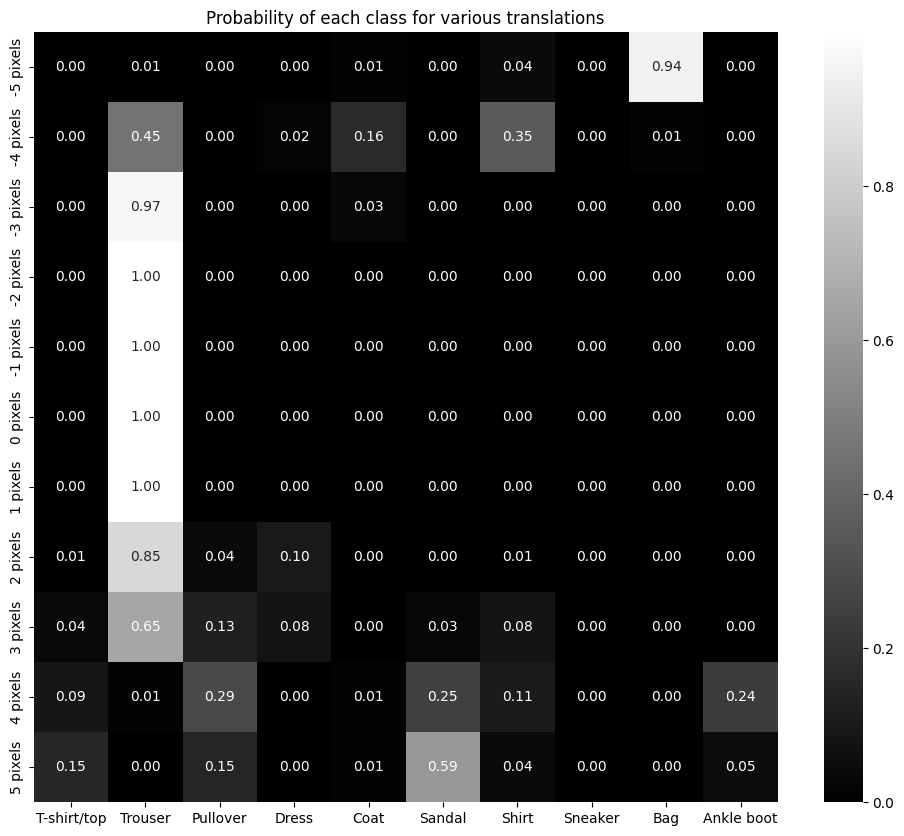

In [29]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')
     

#Scaling a dataset to improve model accuracy


- Modify FMNISTDataset, which fetches data, so that the input image is divided by 255 (the maximum intensity/value of a pixel):

In [30]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix] 
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

from torch.optim import SGD
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    # call your model like any python function on your batch 
    # of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the 
    # gradients of 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) 
    # where "f" is the optimizer
    optimizer.step()
    # Flush memory for next batch of calculations
    optimizer.zero_grad()
    return batch_loss.item()
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()   
    # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
    # compute if the location of maximum in each row 
    # coincides with ground truth
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [31]:
def get_data(): 
    train = FMNISTDataset(tr_images, tr_targets) 
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    return trn_dl

#Train the model over increasing epochs:

In [32]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(5):
    print(epoch)
    epoch_losses, epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, 
                                        loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)

0
1
2
3
4


#However, the Sigmoid value changed considerably in the right-hand table when the input value was small.

The reason for this is that the exponential of a large negative value (resulting from multiplying the weight value by a large number) is very close to 0, while the exponential value varies when the weight is multiplied by a scaled input, as seen in the right-hand table.

Now that we have understood that the Sigmoid value does not change considerably unless the weight values are very small, we will now learn about how weight values can be influenced toward an optimal value.

Scaling the input dataset so that it contains a much smaller range of values generally helps in achieving better model accuracy.

# Understanding the impact of varying the batch size

In the previous section, 32 data points were considered per batch in the training dataset. This resulted in a greater number of weight updates per epoch as there were 1,875 weight updates per epoch (60,000/32 is nearly equal to 1,875, where 60,000 is the number of training images).

Furthermore, we did not consider the model's performance on an unseen dataset (validation dataset). We will explore this in this section.

In this section, we will compare the following:

The loss and accuracy values of the training and validation data when the training batch size is 32.
The loss and accuracy values of the training and validation data when the training batch size is 10,000.
Now that we have brought validation data into the picture, let's rerun the code provided in the Building a neural network section with additional code to generate validation data, as well as to calculate the loss and accuracy values of the validation dataset.

# Understanding the impact of varying the loss optimizer

So far, we have been optimizing loss based on the Adam optimizer. In this section, we will do the following:

Modify the optimizer so that it becomes a Stochastic Gradient Descent (SGD) optimizer
Revert to a batch size of 32 while fetching data in the DataLoader
Increase the number of epochs to 10 (so that we can compare the performance of SGD and Adam over a longer number of epochs)
Making these changes means that only one step in the Batch size of 32 section will change (since the batch size is already 32 in the Batch size of 32 section); that is, we will modify the optimizer so that it's the SGD optimizer.

Let's modify the get_model function in step 4 of the Batch size of 32 section in order to modify the optimzier so that we're using the SGD optimizer instead, as follows:

In [ ]:
"""
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

"""

Increase the number of epochs we'll be using to train the model:

In [26]:
"""
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, \
                                                loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
"""

'\ntrain_losses, train_accuracies = [], []\nval_losses, val_accuracies = [], []\nfor epoch in range(10):\n    train_epoch_losses, train_epoch_accuracies = [], []\n    for ix, batch in enumerate(iter(trn_dl)):\n        x, y = batch\n        batch_loss = train_batch(x, y, model, optimizer,                                                 loss_fn)\n        train_epoch_losses.append(batch_loss) \n    train_epoch_loss = np.array(train_epoch_losses).mean()\n\n    for ix, batch in enumerate(iter(trn_dl)):\n        x, y = batch\n        is_correct = accuracy(x, y, model)\n        train_epoch_accuracies.extend(is_correct)\n    train_epoch_accuracy = np.mean(train_epoch_accuracies)\n\n    for ix, batch in enumerate(iter(val_dl)):\n        x, y = batch\n        val_is_correct = accuracy(x, y, model)\n        validation_loss = val_loss(x, y, model)\n    val_epoch_accuracy = np.mean(val_is_correct)\n\n    train_losses.append(train_epoch_loss)\n    train_accuracies.append(train_epoch_accuracy)\n    v

# Understanding the impact of varying the learning rate


So far, we have been using a learning rate of 0.01 while training our models. In Chapter 1, Artificial Neural Network Fundamentals, we learned that the learning rate plays a key role in attaining optimal weight values. Here, the weight values gradually move toward the optimal value when the learning rate is small, while the weight value oscillates at a non-optimal value when the learning rate is large.

n this section, we will adopt the following strategy:

The steps we need to execute will be exactly the same as in the Batch size of 32 section, when we used the Adam optimizer.
The only change will be in the learning rate in optimizer while we define the get_model function. Here, we'll be changing the learning rate (lr) to a value of 0.1.
Note that all the code remains the same as in the Batch size of 32 section, except for the modifications in the get_model function that we will be making in this section.

In [33]:
"""
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

"""

'\ndef get_model():\n    model = nn.Sequential(\n                nn.Linear(28 * 28, 1000),\n                nn.ReLU(),\n                nn.Linear(1000, 10)\n            ).to(device)\n\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=1e-1)\n    return model, loss_fn, optimizer\n\n'

# Medium learning rate
In this section, we'll reduce the learning rate of the optimizer to 0.001 by modifying the get_model function and retraining the model from scratch.

The modified code for the get_model function is as follows:

In [34]:
"""
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer 


"""


'\ndef get_model():\n    model = nn.Sequential(\n                nn.Linear(28 * 28, 1000),\n                nn.ReLU(),\n                nn.Linear(1000, 10)\n            ).to(device)\n\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=1e-3)\n    return model, loss_fn, optimizer \n\n\n'

#Low learning rate
In this section, we'll reduce the learning rate of the optimizer to 0.00001 by modifying the get_model function and retraining the model from scratch. In addition, we will run the model for a longer number of epochs (100).

The modified code we'll be using for the get_model function is as follows:

Please further check: https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch/tree/master/Chapter03

In [35]:
"""
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-5)
    return model, loss_fn, optimizer 

"""

'\ndef get_model():\n    model = nn.Sequential(\n                nn.Linear(28 * 28, 1000),\n                nn.ReLU(),\n                nn.Linear(1000, 10)\n            ).to(device)\n\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=1e-5)\n    return model, loss_fn, optimizer \n\n'

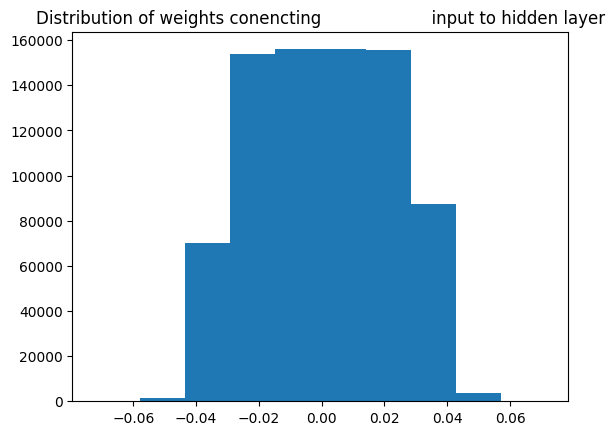

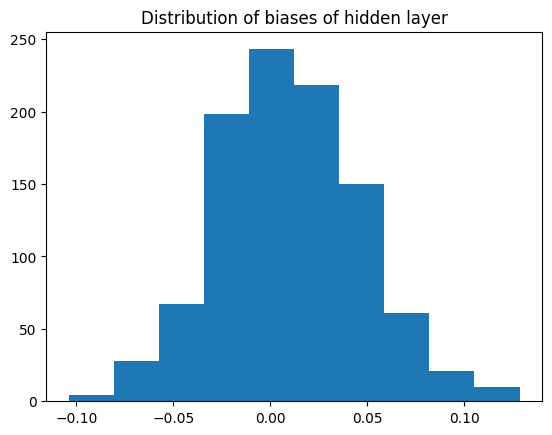

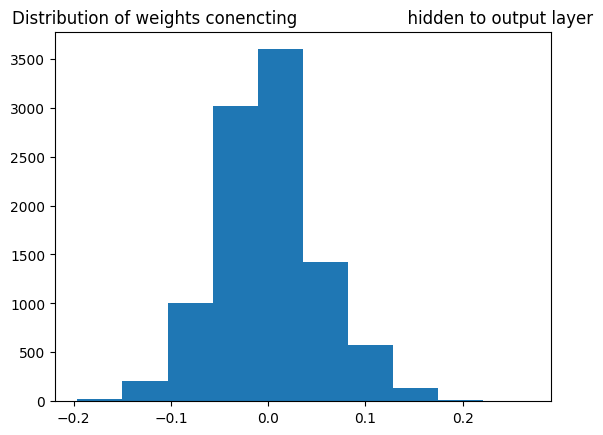

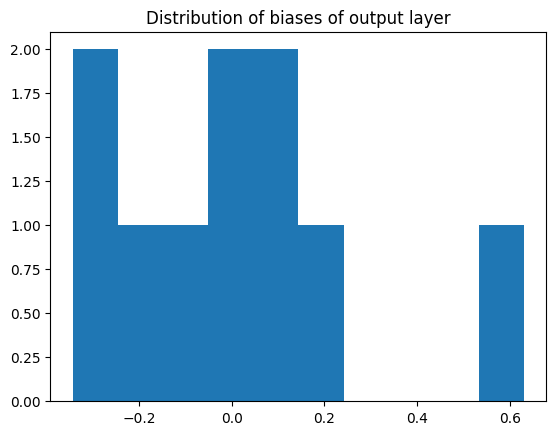

In [36]:
for ix, par in enumerate(model.parameters()):
    if(ix==0):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting \
                    input to hidden layer')
        plt.show()
    elif(ix ==1):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of hidden layer')
        plt.show()
    elif(ix==2):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of weights conencting \
                    hidden to output layer')
        plt.show()
    elif(ix ==3):
        plt.hist(par.cpu().detach().numpy().flatten())
        plt.title('Distribution of biases of output layer')
        plt.show()

Here, we can see the following:

When the learning rate is high, parameters have a much larger distribution compared to medium and low learning rates.
When parameters have a bigger distribution, overfitting occurs.
So far, we've studied the impact of varying the learning rate on a model that's been trained on a scaled dataset. In the next section, we'll learn about the impact of varying the learning rate on a model that's been trained on non-scaled data.

Note that even though we have already established that it is better to always scale input values, we will continue to establish the impact of training a model on a non-scaled dataset.

# Impact of varying the learning rate on a non-scaled dataset
In this section, we will revert to working on a dataset by not performing division by 255 in the class where we define the dataset. This can be done like so:

The code for this section is available as Varying_learning_rate_on_non_scaled_data.ipynb in the Chapter03 folder of this book's GitHub repository - https://tinyurl.com/mcvp-packt . Note that we are not providing all the steps for brevity and that only the steps where there is a change from the code we went through in the Batch size of 32 section will be discussed in the following code. We encourage you to refer to the notebooks in this book's GitHub repository while executing the code.

#Understanding the impact of learning rate annealing
So far, we have initialized a learning rate, and it has remained the same across all the epochs while training the model. However, initially, it would be intuitive for the weights to be updated quickly to a near-optimal scenario. From then on, they should be updated very slowly since the amount of loss that gets reduced initially is high and the amount of loss that gets reduced in the later epochs would be low.

This calls for having a high learning rate initially and gradually lowering it later on as the model achieves near-optimal accuracy. This requires us to understand when the learning rate must be reduced.

In [37]:
"""
from torch import optim
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                    factor=0.5,patience=0,
                                    threshold = 0.001, 
                                    verbose=True, 
                                    min_lr = 1e-5, 
                                    threshold_mode = 'abs')
"""

"\nfrom torch import optim\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,\n                                    factor=0.5,patience=0,\n                                    threshold = 0.001, \n                                    verbose=True, \n                                    min_lr = 1e-5, \n                                    threshold_mode = 'abs')\n"

In [38]:
"""

from torch import optim
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                    factor=0.5, patience=0, 
                                    threshold = 0.001, 
                                    verbose=True, 
                                    min_lr = 1e-5, 
                                    threshold_mode = 'abs')
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(30):
    #print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, \
                                 loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


"""

"\n\nfrom torch import optim\nscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, \n                                    factor=0.5, patience=0, \n                                    threshold = 0.001, \n                                    verbose=True, \n                                    min_lr = 1e-5, \n                                    threshold_mode = 'abs')\ntrain_losses, train_accuracies = [], []\nval_losses, val_accuracies = [], []\nfor epoch in range(30):\n    #print(epoch)\n    train_epoch_losses, train_epoch_accuracies = [], []\n    for ix, batch in enumerate(iter(trn_dl)):\n        x, y = batch\n        batch_loss = train_batch(x, y, model, optimizer,                                  loss_fn)\n        train_epoch_losses.append(batch_loss) \n    train_epoch_loss = np.array(train_epoch_losses).mean()\n\n    for ix, batch in enumerate(iter(trn_dl)):\n        x, y = batch\n        is_correct = accuracy(x, y, model)\n        train_epoch_accuracies.extend(is_correct)\n 

Furthermore, we did not have any huge overfitting issues, even though we trained the model for 100 epochs. This is because the learning rate became so small that the weight update was very small, resulting in a smaller gap between the training and validation accuracies (when compared with the scenario where we had 100 epochs without learning rate annealing, where the training accuracy was close to 100% while the validation accuracy was close to ~89%).

So far, we have learned about the impact various hyperparameters have on the accuracy of a model. In the next section, we will learn about how the number of layers in a neural network impacts its accuracy.

#Building a deeper neural network

A model with two layers within a network can be built as follows (note that we have kept the number of units in the second hidden layer set to 1,000). The modified get_model function (from the code in the Batch size of 32 section), where there are two hidden layers, is as follows:



In [39]:
"""
def get_model():
    model = nn.Sequential(
                nn.Linear(28 * 28, 1000),
                nn.ReLU(),
                nn.Linear(1000, 1000),
                nn.ReLU(),
                nn.Linear(1000, 10)
            ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

"""

'\ndef get_model():\n    model = nn.Sequential(\n                nn.Linear(28 * 28, 1000),\n                nn.ReLU(),\n                nn.Linear(1000, 1000),\n                nn.ReLU(),\n                nn.Linear(1000, 10)\n            ).to(device)\n\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=1e-3)\n    return model, loss_fn, optimizer\n\n'

#Understanding the impact of batch normalization

# The concept of overfitting
So far, we've seen that the accuracy of the training dataset is typically more than 95%, while the accuracy of the validation dataset is ~89%.

We have already learned that whenever loss.backward() is calculated, a weight update happens. Typically, we would have hundreds of thousands of parameters within a network and thousands of data points to train our model on. This gives us the possibility that while the majority of parameters help in training the model reasonably, certain parameters can be fine-tuned for the training images, resulting in their values being dictated by only a few images in the training dataset. This, in turn, results in the training data having a high accuracy but not that the validation dataset generalizes.

Dropout is a mechanism that randomly chooses a specified percentage of activations and drops them to 0. In the next iteration, another random set of hidden units are switched off. This way, the neural network does not optimize for edge cases as the network does not get that many opportunities to adjust the weight to memorize for edge cases (given that the weight is not updated in each iteration).